In [7]:
import numpy as np
import pandas as pd
import copy
import seaborn as sb
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import os
os.environ["PYTHONIOENCODING"] = "utf-8"

In [2]:
raw_data = pd.read_csv('../data/ODI-2020.csv', sep=';')
restore_data = raw_data.copy()

In [3]:
print(raw_data)

What programme are you in?  \
0           Computational Science   
1    Quantitative Risk Management   
2       MSc Computational Science   
3              MSc Finance - QRM    
4                              BA   
..                            ...   
275       Mechenaical Engineering   
276                            CS   
277       Artificial Intelligence   
278       Artificial Intelligence   
279       Artificial Intelligence   

    Have you taken a course on machine learning?  \
0                                             no   
1                                             no   
2                                             no   
3                                             no   
4                                            yes   
..                                           ...   
275                                          yes   
276                                           no   
277                                          yes   
278                                       

In [47]:
raw_data.columns = ['prog', 'ml','ir', 'stat', 'db', 'gender', 'choco', 'birthday', 'nNeigh', 'standup', 'stress', 'dm', 'rand', 'bed', 'gd1', 'gd2']
restore_data.columns = raw_data.columns

In [99]:
# filter needed
# program
prog_mapping = {'phy':'Physics', 'ai':'Artificial Intelligence', 'arti': 'Artificial Intelligence', 'finan':'Finance', 'eng':'Engineer', 'cs':"Computer Science", 'uter scie':"Computer Science", 'ba':"Business", 'business':'Business','econ':'Economy','bioinfo':'Bioinfomatics', 'risk':'QRM', 'comput':'Computational Science', 'bio':"Biology", 'qrm':"QRM", 'information':"Information Science"}
default = lambda x: x[0] if len(x) else 'Others'
raw_data['prog'] = restore_data['prog'].map(lambda x: default([prog_mapping[key] for key in prog_mapping.keys() if key in x.lower()]))
print(raw_data['prog'])

0        Computational Science
1              Risk Management
2        Computational Science
3                      Finance
4                     Business
                ...           
275    Artificial Intelligence
276           Computer Science
277    Artificial Intelligence
278    Artificial Intelligence
279    Artificial Intelligence
Name: prog, Length: 280, dtype: object


In [31]:
# map values
to_be_mapped = ['ml', 'db', 'stat', 'ir', 'gender', 'standup', 'choco', 'nNeigh']
for col in to_be_mapped:
    val_set = sorted(set(restore_data[col]))
    val_dict = {val:i for i, val in enumerate(val_set)}
    raw_data[col] = restore_data[col].map(lambda x: val_dict[x])


114                                             Exchange
125                                      Health sciences
126               Human movement science research master
133                            Human Language Technology
155                                                  MSc
180            Research Master Human Language Technology
182                                                  EOR
187    Human Language Technologies (Humanities Research)
205                                  MSc Datascience UVA
214                                             exchange
215                                             exchange
224                                                  CLS
237                                                  CPS
245                              Master Forensic Science
257                                              Fintech
258                                              Erasmus
Name: prog, dtype: object


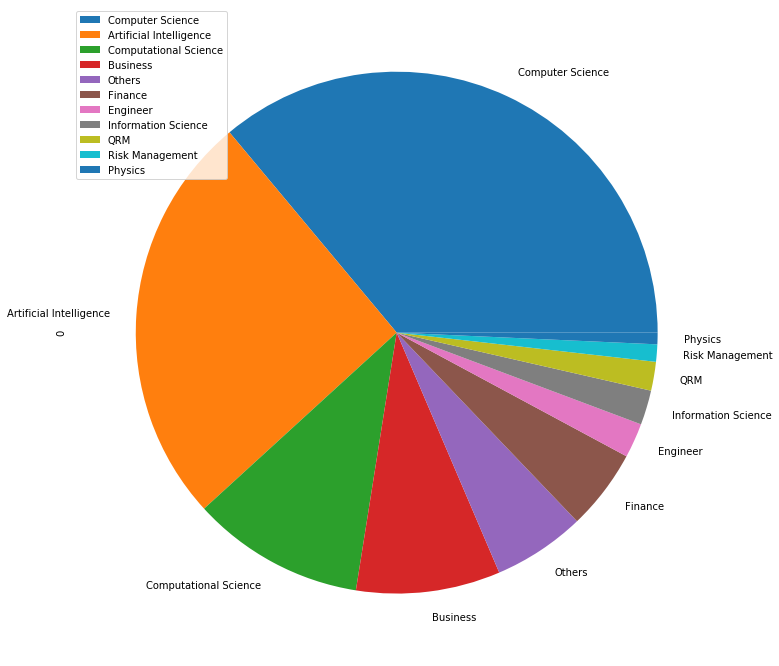

In [100]:
# draw for the previous values
# first for the prog
# raw_data.plot.pie(y='prog')
tmpd = dict(raw_data['prog'].value_counts())
print(restore_data['prog'][raw_data['prog']=='Others'])
# print(tmpd)
tmpdf = pd.DataFrame(tmpd.values(), index=tmpd.keys())
tmpdf.plot.pie(subplots=True, figsize=(12,12))
plt.legend(loc='upper left')
del tmpd, tmpdf

In [59]:
#find a heatmap upon the opinions to choco and sex
# print(raw_data['choco'].corr(raw_data['gender']))
def ExtractNumber(item):
    if isinstance(item, float):
        num = item
    elif isinstance(item, int):
        num = float(item)
    elif isinstance(item, str):
        nstr = re.findall(r'\d+\.?\d*', item)
        nlist = list(map(float,nstr))
        if len(nlist) == 0:
            num = float('NaN')
        else:
            num = nlist[0]
    else:
        num = float('NaN')
    return num


In [66]:

raw_data['nNeigh'] = raw_data['nNeigh'].map(ExtractNumber)
raw_data['dm'] = raw_data['dm'].map(ExtractNumber)
raw_data['stress'] = restore_data['stress'].map(ExtractNumber)

In [74]:
def bedtime(s):
    if type(s)==str:
        cands = re.findall(r"^([0-1][0-9]|[2][0-3]):([0-5][0-9])$", s)
        if (len(cands)):
            return cands[0]
    return ('00', '00')

raw_data['bed'] = restore_data['bed'].map(bedtime)

In [75]:
raw_data['bed'][0]

('22', '30')

In [81]:
# dt_re = r"^\d{4}\-(0?[1-9]|1[012])\-(0?[1-9]|[12][0-9]|3[01])$"
def birthday(s):
    if type(s)==str:
        cands = re.findall(dt_re, s)
        print(cands)
        if (len(cands)):
            return cands[0]
    return ('00', '00')
# raw_data['birthday'] = restore_data['birthday'].map(birthday)

In [76]:
def InvalidValue(minv, maxv, item):
    if item < minv or item > maxv:
        item = float('NaN')
    return item
raw_data['dm'] = raw_data['dm'].map(lambda x: InvalidValue(0, 100, x))
raw_data['nNeigh'] = raw_data['nNeigh'].map(lambda x: InvalidValue(0, 10, x))

In [101]:
majors = sorted(set(raw_data['prog']))
reverse_mj = {n:i for i, n in enumerate(majors)}
tmp = np.zeros((len(raw_data['prog']), len(majors)), dtype='int32')
for i in range(len(tmp)):
    tmp[i][reverse_mj[raw_data['prog'][i]]] = 1
tmp_df = pd.DataFrame(tmp, columns = list(majors))
# print(tmp_df)
tmp_df.to_csv('../data/ODI_pro.csv', index=False, encoding='utf-8')

del tmp, reverse_mj, tmp_df

In [102]:
print(majors)

['Artificial Intelligence', 'Business', 'Computational Science', 'Computer Science', 'Engineer', 'Finance', 'Information Science', 'Others', 'Physics', 'QRM', 'Risk Management']


In [11]:
v = TfidfVectorizer()


In [12]:

with open('../data/SmsCollection.csv', 'rb') as f:
    smstexts = f.readlines()
smstexts = [text.decode('utf-8')[:-1] for text in smstexts]
smstexts = smstexts[1:]
truetable =  {'ham':0, 'spam':1}
labels = [truetable[text.split(';')[0]] for text in smstexts]
# prunctuations = ['.', ',', '?', '', '/', '=', ':', '>', '!', '']
def dealStr(s:str):
    s = ' '.join(s.split(';')[1:])
    # s.replace('.')
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s
x = [dealStr(s) for s in smstexts]
print(x)
features = v.fit_transform(x)


 do you call it work now', 'Jolly good By the way  will give u tickets for sat eve 730 Speak before then x', 'yeah thats what I was thinking', 'Kkim going to tirunelvali this week to see my uncle i already spend the amount by taking dress so only i want moneyi will give it on feb 1', 'Here got ur favorite oyster N got my favorite sashimi Ok lar i dun say already Wait ur stomach start rumbling', 'My sister going to earn more than me da', 'Get the official ENGLAND poly ringtone or colour flag on yer mobile for tonights game Text TONE or FLAG to 84199 Optout txt ENG STOP Box39822 W111WX £150', 'Hahahause your brain dear', 'Jus finish watching tv U', 'K fyi Im back in my parents place in south tampa so I might need to do the deal somewhere else', 'Good morning my Love  I go to sleep now and wish you a great day full of feeling better and opportunity  You are my last thought babe I LOVE YOU kiss', 'Kothi print out marandratha', 'But we havent got da topic yet rite', 'Ok no problem Yup im go

In [13]:

print(len(labels))
print(features.shape)

5574
(5574, 9534)


In [14]:


import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

LR = linear_model.LogisticRegression() 
# features = ['Artificial Intelligence', 'Business', 'Computational Science', 'Computer Science', 'Engineer', 'Finance', 'Information Science', 'Others', 'Physics', 'QRM',
            # 'information retrieval','statistics','databases','DM']
X = features
# Y = ODI['stress level']
Y = labels
LR.fit(X,Y)
scores_LR = cross_val_score(LR, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_LR)) #求平均的交叉检验的值


0.9562231745847892


In [15]:
# KNN
from sklearn import neighbors
KNN = neighbors.KNeighborsClassifier()
KNN.fit(X, Y)
scores_KNN = cross_val_score(KNN, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_KNN))

0.9273572582253881


In [24]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(max_depth=3)
gbc.fit(X, Y)
scores_gbc = cross_val_score(gbc, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_gbc))

0.9657303913051873


In [17]:
# Random forests
rfm = RandomForestClassifier(n_estimators=100)
rfm.fit(X, Y)
scores_rfm = cross_val_score(rfm, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_rfm))

0.970036614479772


In [23]:
# SVM
svc = SVC(C=0.01)
svc.fit(X, Y)
scores_svc = cross_val_score(svc, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_svc))

0.8659852126406827


In [19]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X, Y)
scores_gnb = cross_val_score(gnb, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_gnb))

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [21]:
# 
dt = DecisionTreeClassifier()
dt.fit(X, Y)
scores_dt = cross_val_score(dt, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_dt))

0.9589116683719106
